## Importing required libraries

In [1]:
!pip install albumentations
!pip install torch-lr-finder
!pip install torchsummary
!pip install gradcam

from __future__ import print_function
import torch
import torch.optim as optim
import albumentations as A
import cv2
from albumentations.pytorch import ToTensorV2
import torch.nn as nn
from torch.optim.lr_scheduler import OneCycleLR

import train_test
from models.resnet import ResNet18
from utils import *
from train_test import *
from visualize import *

/usr/local/lib/python3.10/dist-packages/torch_lr_finder/lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
SEED = 1
# CUDA
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Device used: ", device)

# For reproducibility
torch.manual_seed(SEED)
if use_cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments
dataloader_args = dict(shuffle=True, batch_size=512, num_workers=2, pin_memory=True)

# From utils importing Cifar10SearchDataset, dataloader
train_data = Cifar10SearchDataset(train=True, download=True, transform="train")
test_data = Cifar10SearchDataset(train=False, download=True, transform="test")

train_loader = dataloader(train_data, dataloader_args)
test_loader = dataloader(test_data, dataloader_args)

# specify the image classes
classes = train_data.classes
print("Unique classes of images are:", classes)

Device used:  cuda


100%|██████████| 170498071/170498071 [00:02<00:00, 77885405.71it/s]


Extracting /root/data/cifar10/cifar-10-python.tar.gz to /root/data/cifar10


/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/dropout/cutout.py:50: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(


Files already downloaded and verified
Unique classes of images are: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


## Initializing model and model summary
(from custom_resnet_model)

In [7]:
# using batch norm
model = ResNet18().to(device)
model.model_summary((3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
              ReLU-2           [-1, 64, 32, 32]               0
       BatchNorm2d-3           [-1, 64, 32, 32]             128
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
              ReLU-6          [-1, 128, 16, 16]               0
       BatchNorm2d-7          [-1, 128, 16, 16]             256
            Conv2d-8          [-1, 128, 16, 16]         147,456
              ReLU-9          [-1, 128, 16, 16]               0
      BatchNorm2d-10          [-1, 128, 16, 16]             256
           Conv2d-11          [-1, 128, 16, 16]         147,456
             ReLU-12          [-1, 128, 16, 16]               0
      BatchNorm2d-13          [-1, 128, 16, 16]             256
           Conv2d-14          [-1, 256,

  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 2.48E-04


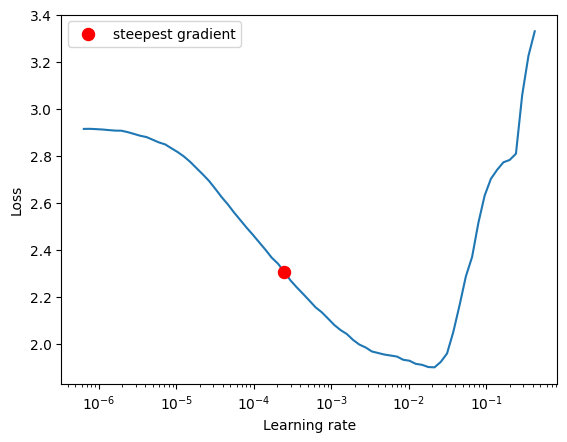

In [8]:
optimizer = optim.SGD(cnn_model.parameters(), lr=0.01, momentum=0.9)
lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=5, verbose=True)

EPOCHS = 20

for epoch in range(EPOCHS):
    print("EPOCH:", epoch + 1)
    train(cnn_model, device, train_loader, optimizer, epoch)
    misclassified_images, misclassified_labels, misclassified_predictions = test(cnn_model, device, test_loader)
    lr_scheduler.step(train_test.test_losses[-1])  # Adjust learning rate based on validation loss

# Model Training and Prediction


## Train and Test Loss/Accuracy
(from visualize module)

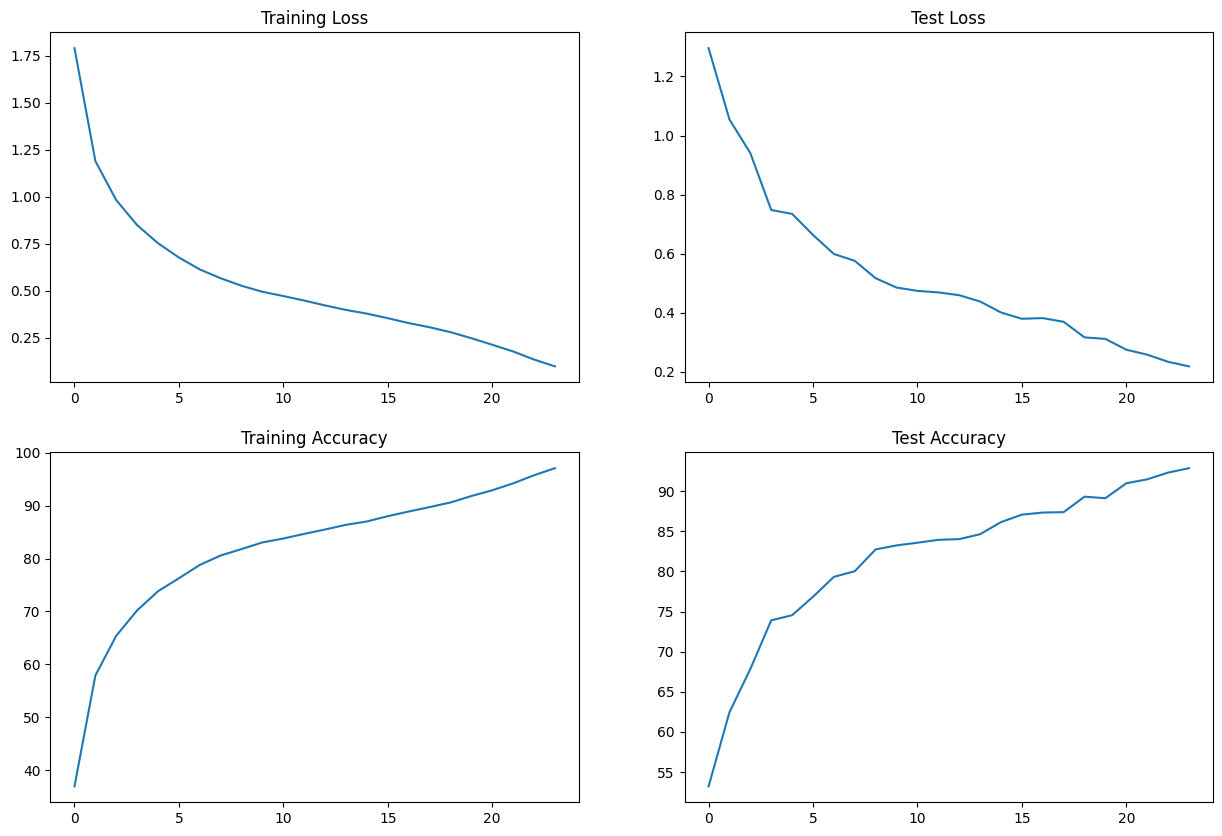

In [10]:
show_accuracy_loss(train_test.train_losses, train_test.train_accuracies, train_test.test_losses, train_test.test_accuracies)

## Misclassified Images
(from visualize module)

Misclassified Images:


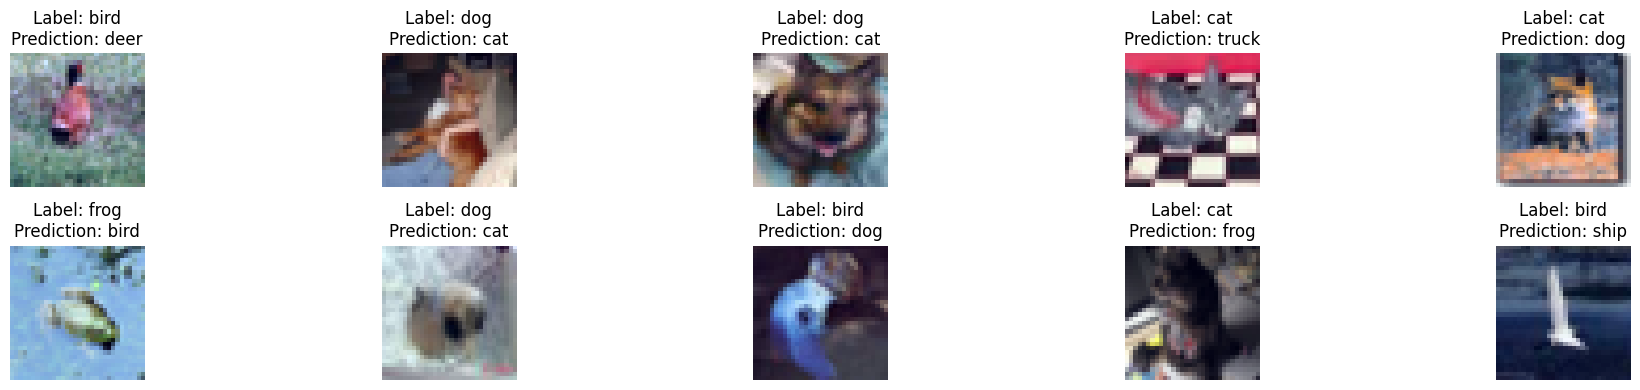

In [11]:
show_misclassified_img(misclassified_images, misclassified_labels, misclassified_predictions, classes)